# 5.1 Computational Graph
# 5.2 Chain Rule
# 5.3 Backpropagation

# 5.4 단순한 계층 구현
## 5.4.1 곱셈 계층

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

In [2]:
mul_applenum_appleprice_layer = MulLayer()
mul_totalprice_tax_layer = MulLayer()

In [3]:
# forward
apple_num, apple_price, tax = 2, 100, 1.1

totalprice = mul_applenum_appleprice_layer.forward(apple_num, apple_price)
totalprice_tax = mul_totalprice_tax_layer.forward(totalprice, tax)

In [4]:
# backward
dtotalprice_tax = 1
dtotalprice, dtax = mul_totalprice_tax_layer.backward(dtotalprice_tax)
dapple_num, dapple_price = mul_applenum_appleprice_layer.backward(dtotalprice)

print(dtotalprice, dtax, round(dapple_num, 1), dapple_price)

1.1 200 110.0 2.2


## 5.4.2 덧셈 계층

In [5]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [6]:
apple_num, apple_price = 2, 100
orange_num, orange_price = 3, 150
tax = 1.1

apple_mul_layer = MulLayer()
orange_mul_layer = MulLayer()
apple_orange_add_layer = AddLayer()
totalprice_tax_mul_layer = MulLayer()

In [7]:
# forward
apple_totalprice = apple_mul_layer.forward(apple_num, apple_price)
orange_totalprice = orange_mul_layer.forward(orange_num, orange_price)
totalprice = apple_orange_add_layer.forward(apple_totalprice, orange_totalprice)
totalprice_tax = totalprice_tax_mul_layer.forward(totalprice, tax)

print(apple_totalprice, orange_totalprice, totalprice, round(totalprice_tax, 1))

200 450 650 715.0


In [8]:
# backward
dtotalprice_tax = 1
dtotalprice, dtax = totalprice_tax_mul_layer.backward(dtotalprice_tax)

dapple_totalprice, dorange_totalprice = apple_orange_add_layer.backward(dtotalprice)
dapple_num, dapple_price = apple_mul_layer.backward(dapple_totalprice)
dorange_num, dorange_price = orange_mul_layer.backward(dorange_totalprice)

print(round(dapple_num, 1), dapple_price, dorange_num, round(dorange_price, 1), dtax)

110.0 2.2 165.0 3.3 650


# 5.5 활성화 함수 계층 구현
## 5.5.1 ReLU 계층

In [9]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dx = dout.copy()
        dx[self.mask] = 0
        return dx

## 5.5.2 Sigmoid 계층

In [10]:
class sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1 - self.out) * self.out
        return dx

# 5.6 Affine/Softmax 계층 구현
## 5.6.1, 5.6.2 Affine 계층

In [11]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x, self.dW, self.db = None, None, None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        return dx

## 5.6.3 Softmax-with-Loss 계층

In [12]:
def softmax(x):
    nom = np.exp(x - np.max(x, axis = 1)[:, np.newaxis])
    denom = np.sum(nom, axis = 1)[:, np.newaxis]
    return nom / denom

def cross_entropy_error(y, t):
    delta = 1e-7
    if y.ndim != 1 and t.ndim != 1:
        t = t.flatten()
        y = y.flatten()
        return -np.sum(t*np.log(y + delta) / y.shape[0]) 
    else:
        return -np.sum(t*np.log(y + delta)) 

In [13]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.t = None
        self.y = None
        
    def forward(self, x, t):
        self.y = softmax(x)
        self.t = t
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout = 1):
        batch_size = self.y.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

# 5.7 오차역전파법 구현하기

In [14]:
from collections import OrderedDict
import numpy as np

In [15]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = np.random.normal(size = (input_size, hidden_size)) * weight_init_std
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = np.random.normal(size = (hidden_size, output_size)) * weight_init_std
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastlayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        loss = self.lastlayer.forward(y, t)
        return loss
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        t = np.argmax(t, axis = 1)
        return np.sum(y == t) / x.shape[0]
    
    def gradient(self, x, t):
        # 순전파 - 미분값들 저장
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.lastlayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

In [16]:
from tensorflow.python.keras.datasets.mnist import load_data

(X_train, y_train), (X_test,y_test) = load_data()
X_train, X_test = X_train.reshape(60000,-1) / 255, X_test.reshape(10000, -1) / 255

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))
y_train, y_test = enc.transform(y_train.reshape(-1, 1)).toarray(), enc.transform(y_test.reshape(-1, 1)).toarray()

In [17]:
def mini_batch(x, y, batch_size):
    mask = np.random.choice(x.shape[0], batch_size)
    return x[mask], y[mask]

In [18]:
iters_num = 10000
batch_size = 150
iters_per_epoch = X_train.shape[0] / batch_size
learning_rate = 0.1
train_loss, train_accuracy, test_accuracy = [], [], []

net = TwoLayerNet(input_size = X_train.shape[1], hidden_size = 50, output_size = 10)
for i in range(iters_num):
    x_batch, y_batch = mini_batch(X_train, y_train, batch_size)
    
    grads = net.gradient(x_batch, y_batch)
    
    for grad in grads.keys():
        net.params[grad] -=  learning_rate * grads[grad]
        
    if i % iters_per_epoch == 0:
        loss = net.loss(X_train, y_train)
        train_acc, test_acc = net.accuracy(X_train, y_train), net.accuracy(X_test, y_test)
        train_loss.append(loss)
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        
        print("{0}th loss : {1}, train accuracy : {2}, test accuracy is : {3}".format(i, loss, train_acc, test_acc))

0th loss : 0.2301676215231189, train accuracy : 0.15538333333333335, test accuracy is : 0.1508
400th loss : 0.038001017950710266, train accuracy : 0.894, test accuracy is : 0.8966
800th loss : 0.03053793956245532, train accuracy : 0.9131833333333333, test accuracy is : 0.9162
1200th loss : 0.027045674931221585, train accuracy : 0.9222166666666667, test accuracy is : 0.924
1600th loss : 0.023809443439539425, train accuracy : 0.9327833333333333, test accuracy is : 0.9331
2000th loss : 0.021749680680547792, train accuracy : 0.9398666666666666, test accuracy is : 0.9388
2400th loss : 0.01958999946097577, train accuracy : 0.9447166666666666, test accuracy is : 0.9422
2800th loss : 0.018006157762278173, train accuracy : 0.94975, test accuracy is : 0.9471
3200th loss : 0.01669176894138726, train accuracy : 0.95295, test accuracy is : 0.9513
3600th loss : 0.01578119230189514, train accuracy : 0.9547333333333333, test accuracy is : 0.9518
4000th loss : 0.014607211675359152, train accuracy : 0.9

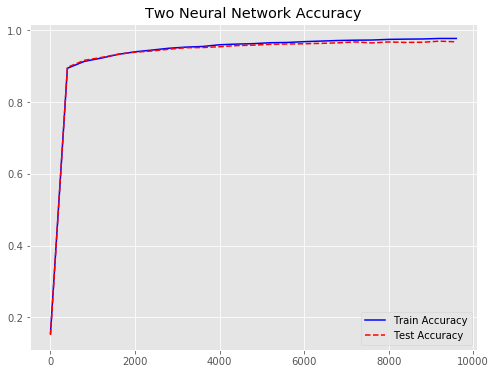

In [19]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize = (8, 6))
x = list(range(0, 10 ** 4, 400))
plt.plot(x, train_accuracy, 'b', label = 'Train Accuracy')
plt.plot(x, test_accuracy, 'r--', label = 'Test Accuracy')
plt.title('Two Neural Network Accuracy')
plt.legend()
plt.show()